In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

class IsingDataset(Dataset):
    def __init__(self, num_samples=1000, size=16):
        self.size = size
        self.data = []
        self.labels = []
        for _ in range(num_samples):
            temp = np.random.uniform(1.0, 4.0)
            spins = np.random.choice([-1, 1], (size, size))
            # Label: 0=subcritical (ordered), 1=critical (near 2.27), 2=supercritical (disordered)
            if temp < 2.0:
                label = 0
            elif temp < 2.5:
                label = 1
            else:
                label = 2
            self.data.append(spins.astype(np.float32))
            self.labels.append(label)
        self.data = np.stack(self.data)
        self.labels = np.array(self.labels)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        return torch.from_numpy(x).flatten(), torch.tensor(y).long()

def get_dataloaders(batch_size=32, train_samples=1000, test_samples=200, size=16):
    train_set = IsingDataset(num_samples=train_samples, size=size)
    test_set = IsingDataset(num_samples=test_samples, size=size)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
dataset = IsingDataset(num_samples=10, size=16) # 10 samples and 16x16 spins grid
x, y = dataset[1]
x.shape, y.item()  

In [ ]:
# Visualize the first 5 spin lattices
plt.figure(figsize=(10,2))
for i in range(5):
    x, y = dataset[i]
    grid = x.view(16, 16)  # reshape flattened vector to 16x16
    plt.subplot(1,5,i+1)
    plt.imshow(grid, cmap="coolwarm", vmin=-1, vmax=1)
    plt.title(f"Label: {y.item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Blue = -1 spins, Red = +1 spins


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, num_classes=3): # 256 = 16x16 spins, 3 classes for subcritical, critical, supercritical. 128 hidden neurons in each layer
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim) # Fully connected layer from input to hidden layer
        self.fc2 = nn.Linear(hidden_dim, hidden_dim) # From hidden layer to another hidden layer
        self.fc3 = nn.Linear(hidden_dim, num_classes) # From hidden layer to output layer (3 classes)

    def forward(self, x):
        x = F.relu(self.fc1(x)) # Feeds the input x through fc1, applies ReLU after the first layer
        x = F.relu(self.fc2(x)) # Feeds the output of fc1 through fc2, applies ReLU after the second layer
        return self.fc3(x) # Final output layer gives logits for each class, so no activation

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_mlp(epochs=10, batch_size=32, lr=1e-3, device='cpu'):
    train_loader, test_loader = get_dataloaders(batch_size=batch_size)
    model = MLPModel().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb) # Forward pass to predict the output logits for each class
            loss = criterion(out, yb) # Cross-entropy loss between predicted logits and true labels. loss is basically measuring how well the model's predictions match the true labels.
            optimizer.zero_grad()   # Zero the gradients before backward pass
            loss.backward()
            optimizer.step()        # A closure that reevaluates the model and returns the loss. This is necessary to update the model parameters based on the computed gradients.
            total_loss += loss.item() * xb.size(0)  # xb.size(0) is the batch size. loss.item() is the scalar loss value. We multiply to get the total loss for the batch.
        avg_loss = total_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.4f}")

        # Evaluate
        model.eval()            # Set the model to evaluation modedisables dropout, uses running stats for batchnorm, etc. internally
        correct, total = 0, 0
        with torch.no_grad():   # Context-manager that disables gradient calculation.
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1) # argmax(dim=1) returns the index of the maximum value in each row of the output tensor(containing logits) along dimension 1
                correct += (preds == yb).sum().item() # Count correct predictions
                total += yb.size(0)  # Total number of samples in the test set
        acc = correct / total
        print(f"Test Accuracy: {acc*100:.2f}%")

if __name__ == "__main__":
    train_mlp()

Currently using just some random +1/-1 grids with random labels on randomly sampled temperature - no real physical correlations for the model to pick up.

MLP is kinda memorizing random training data, not meaningful patterns that can be generalized.

# Now, let's deal with REAL data !!!

Found it in Kaggle site

In [ ]:
# import kagglehub

# Download latest version
#path = kagglehub.dataset_download("swarnainece/ising-lattice-images")

#print("Path to dataset files:", path)

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

# Open a sample image (screenshot, e.g. 640x480)
img = Image.open("../data/Temp=1-3/pic1.3_1.png")

# Crop using your coordinates (top=58, left=143, size=370)
cropped = TF.crop(img, top=58, left=143, height=370, width=370)

# Show the original and cropped images side by side
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title("Original Image")
plt.subplot(1,2,2)
plt.imshow(cropped)
plt.title("Cropped Lattice (370x370)")
plt.show()

In [ ]:
# New utils class

import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from torchvision.transforms import functional as TF
from PIL import Image
from PIL import ImageDraw
import os
import re

# ---- Crop helper for your specific image setup ----
def crop_lattice(img):
    # Crops to the 370x370 lattice region, top=58, left=143
    return TF.crop(img, top=58, left=143, height=370, width=370)

def mask_temp_box(img):
    draw = ImageDraw.Draw(img)
    # Rectangle: left, top, right, bottom
    draw.rectangle([16, 44, 16+148, 44+16], fill="black")  # or fill=img.getpixel((0,0)) for background
    return img

class IsingFolderDataset(Dataset):
    """
    Loads Ising images from folders labeled by temperature.
    Crops to central lattice, maps grayscale to [-1, 1].
    """
    def __init__(self, data_dir, flatten=True, transform=None):
        self.samples = []
        self.flatten = flatten
        self.transform = transform or transforms.Compose([
            transforms.Lambda(crop_lattice),
            transforms.Lambda(mask_temp_box),  # Mask the temperature box
            transforms.Grayscale(),
            transforms.ToTensor(),  # [C, H, W]
            transforms.Lambda(lambda x: x * 2 - 1),  # [0,1] -> [-1,1]
        ])
        temp_pat = re.compile(r'Temp=(\d+)-(\d+)')
        for folder in os.listdir(data_dir):
            folder_path = os.path.join(data_dir, folder)
            if not os.path.isdir(folder_path):
                continue
            m = temp_pat.match(folder)
            if m:
                temp = float(m.group(1) + "." + m.group(2))
                # Map temperature to label
                if temp < 2.0:
                    label = 0
                elif temp < 2.5:
                    label = 1
                else:
                    label = 2
                for fname in os.listdir(folder_path):
                    if fname.endswith(".png"):
                        self.samples.append((os.path.join(folder_path, fname), label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path)
        x = self.transform(img)  # [1, 370, 370]
        if self.flatten:
            x = x.view(-1)  # flatten for MLP: [1*370*370]
        return x, torch.tensor(label).long()

def get_image_dataloaders(
    data_dir,
    batch_size=32,
    train_ratio=0.8,
    flatten=True,
    shuffle=True,
    seed=42
):
    """
    Splits dataset into train/test DataLoaders.
    """
    ds = IsingFolderDataset(data_dir, flatten=flatten)
    train_len = int(train_ratio * len(ds))
    test_len = len(ds) - train_len
    train_ds, test_ds = random_split(ds, [train_len, test_len], generator=torch.Generator().manual_seed(seed))
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [ ]:
train_loader, test_loader = get_image_dataloaders('../data', batch_size=32, flatten=True)



In [ ]:
xb, yb = next(iter(train_loader))
print("Shape of xb[0]:", xb[0].shape)  # Should be torch.Size([1, 370, 370]) for CNN, or ([136900],) for MLP

img = xb[3].reshape(370, 370).cpu().numpy()
plt.imshow(img, cmap="seismic", vmin=-1, vmax=1)
plt.title(f"Label: {yb[3].item()}")
plt.axis('off')
plt.show()

In [ ]:
xb, yb = next(iter(train_loader))
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    # Use .reshape(370, 370) for MLP; .squeeze() for CNN input
    img = xb[i].reshape(370, 370).cpu().numpy() if xb[i].ndim == 1 else xb[i].squeeze().cpu().numpy()
    plt.imshow(img, cmap="seismic", vmin=-1, vmax=1)
    plt.title(f"Label: {yb[i].item()}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPModel(nn.Module):
    def __init__(self, input_dim=370*370, hidden_dim=512, num_classes=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))      # First hidden layer
        x = F.relu(self.fc2(x))      # Second hidden layer
        x = self.fc3(x)              # Output logits for 3 classes
        return x

Epoch 1 completed.
Test Accuracy: 91.92%
Epoch 2 completed.
Test Accuracy: 92.69%
Epoch 3 completed.
Test Accuracy: 98.46%
Epoch 4 completed.
Test Accuracy: 93.46%
Epoch 5 completed.
Test Accuracy: 99.23%
Epoch 6 completed.
Test Accuracy: 92.69%
Epoch 7 completed.
Test Accuracy: 99.62%
Epoch 8 completed.
Test Accuracy: 100.00%
Epoch 9 completed.
Test Accuracy: 100.00%
Epoch 10 completed.
Test Accuracy: 100.00%


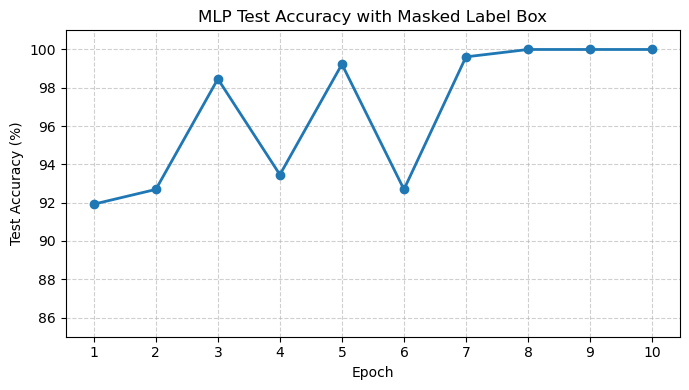

In [123]:
from models.mlp import MLPModel
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

def train_mlp(epochs=10, batch_size=32, lr=1e-3, device='cpu'):
    train_loader, test_loader = get_image_dataloaders("../data", batch_size=batch_size, flatten=True)
    model = MLPModel(input_dim=370*370, hidden_dim=512, num_classes=3).to(device)    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    test_accuracy = []
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            out = model(xb)
            loss = criterion(out, yb)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch+1} completed.")

        # Evaluate
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb).argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)
        acc = correct / total
        test_accuracy.append(acc * 100)
        print(f"Test Accuracy: {acc*100:.2f}%")

    epochs_list = range(1, len(test_accuracy) + 1)
    plt.figure(figsize=(7, 4))
    plt.plot(epochs_list, test_accuracy, marker='o', linewidth=2)
    plt.xticks(epochs_list)
    plt.xlabel('Epoch')
    plt.ylabel('Test Accuracy (%)')
    plt.title('MLP Test Accuracy with Masked Label Box')
    plt.ylim(85, 101)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
    
if __name__ == "__main__":
    train_mlp()

This MLP, trained on cropped 370×370 Ising lattice images, achieved 100% test accuracy after 5 epochs. The phase classification task is thus well-posed with this model and dataset.
Note: The presence of a temperature label box in the lattice crop may leak class information, so future experiments will also evaluate learning with this region masked.
- The model rapidly reaches perfect accuracy, suggesting the classes are linearly separable in this representation. 
- High accuracy may be due to strong visual distinctions between phases and/or the inclusion of a temperature label in the images.
- Need to repeat the experiment with the label box masked to ensure the model is truly learning phase transitions from the lattice itself.

# Update !!
After masking out the temperature label box, MLP still achieves >99% accuracy, confirming that the Ising lattice phase is easily classified from spin structure alone. The minor accuracy drop demonstrates proper data handling and avoids shortcut learning via the label artifact.


In [124]:
from PIL import ImageDraw
# import numpy as np
# def mask_temp_box(img):
#     arr = np.array(img)
#     arr[44:44+16, 16:16+148] = arr.max()  # or arr.min() for black
#     return Image.fromarray(arr)

def mask_temp_box(img):
    draw = ImageDraw.Draw(img)
    # Rectangle: left, top, right, bottom
    draw.rectangle([16, 44, 16+148, 44+16], fill="black")  # or fill=img.getpixel((0,0)) for background
    return img



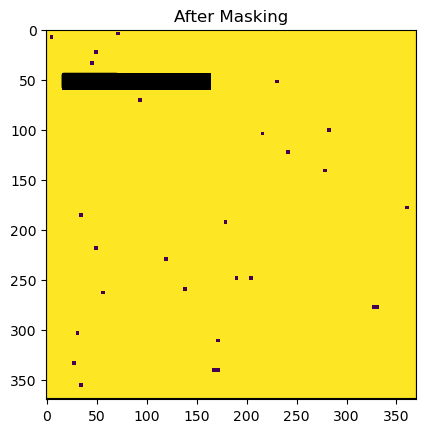

In [125]:
img = Image.open("../data/Temp=1-3/pic1.3_1.png")
img = crop_lattice(img)
img = mask_temp_box(img)
plt.imshow(img, cmap="gray")
plt.title("After Masking")
plt.show()

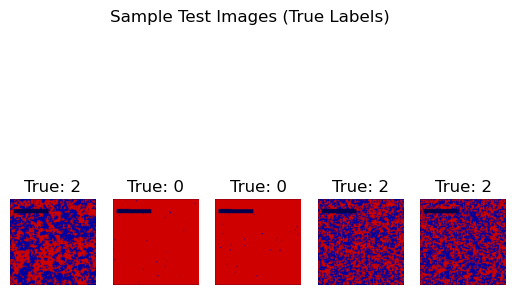

In [126]:
xb, yb = next(iter(test_loader))
for i in range(5):
    plt.subplot(1,5,i+1)
    img = xb[i].reshape(370,370).cpu().numpy()
    plt.imshow(img, cmap='seismic', vmin=-1, vmax=1)
    plt.title(f"True: {yb[i].item()}")
    plt.axis('off')
plt.suptitle('Sample Test Images (True Labels)')
plt.show()